# Recommendation System
### Using Matrix Factorization and Neural Collaborative Filtering

During this experiment we will be testing Matrix Factorization and Neural Collaborative Filtering for recommendation engines, using Movie Lens 20 Millions Dataset

References:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=<http://dx.doi.org/10.1145/2827872>

Exploratory Data Analysis, Model Definition, Training and Fine-Tunning described step by step on this Notebook

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
clear_output()

In [0]:
#Downloads and extract Dataset to local, wait for download, i dont want to put a progress bar here sorry
#You can run this on google colab for get faster downloads speeds
import os
import zipfile
import requests

if(not os.path.exists("./Datasets/MoviLens20M.zip")):

  resp = requests.get("http://files.grouplens.org/datasets/movielens/ml-20m.zip")

  os.mkdir("./Datasets")

  with open("./Datasets/MoviLens20M.zip", "wb") as f:
    f.write(resp.content)

  with zipfile.ZipFile("./Datasets/MoviLens20M.zip", "r") as zip_ref:
    zip_ref.extractall("./Datasets")


In [0]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')
clear_output()

## Exploratory Data Analysis

Simple exploration without too much fancy graphs

In [0]:
#Loads Dataset, we only need ratings.csv and movies.csv files, we can drop timestamp and genres for now
ratings_df = pd.read_csv("./Datasets/ml-20m/ratings.csv").drop(["timestamp"], axis=1)
movies_df = pd.read_csv("./Datasets/ml-20m/movies.csv").drop(["genres"], axis=1)

ml_df = ratings_df.merge(movies_df, on="movieId")

ml_df = ml_df.reindex(columns=["userId", "movieId", "title", "rating"])
ml_df.head()

,userId,movieId,title,rating
0,1,2,Jumanji (1995),3.5
1,5,2,Jumanji (1995),3.0
2,13,2,Jumanji (1995),3.0
3,29,2,Jumanji (1995),3.0
4,34,2,Jumanji (1995),3.0


In [0]:
#Check info about the Dataset
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId     int64
movieId    int64
title      object
rating     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 762.9+ MB


In [0]:
#Check for NaNs
ml_df.isna().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [0]:
#List unique values of each column
n_users = ml_df["userId"].max()
n_movies = ml_df["movieId"].nunique()

print("Unique Users: " + str(n_users))
print("Unique Movies: " + str(n_movies))

Unique Users: 138493
Unique Movies: 26744


In [0]:
#Top movies with more rating count (dont confuse with more views or more rating score, but are correlated)
count = ml_df["title"].value_counts()
count[:15]

Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Toy Story (1995)                             49695
Fugitive, The (1993)                         49581
Apollo 13 (1995)                             47777
Independence Day (a.k.a. ID4) (1996)         47048
Usual Suspects, The (1995)                   47006
Name: title, dtype: int64

## Preprocessing

In [0]:
#Normalize ratings
ml_df["rating_norm"] = ml_df["rating"] / 5.0

#Set Ids as categorical data
ml_df["userId"] = ml_df["userId"].astype("category").cat.codes.values
ml_df["movieId"] = ml_df["movieId"].astype("category").cat.codes.values
ml_df.head()

,userId,movieId,title,rating,rating_norm
0,0,1,Jumanji (1995),3.5,0.7
1,4,1,Jumanji (1995),3.0,0.6
2,12,1,Jumanji (1995),3.0,0.6
3,28,1,Jumanji (1995),3.0,0.6
4,33,1,Jumanji (1995),3.0,0.6


In [0]:
#Redimension Target data.
users = ml_df["userId"].values
movies = ml_df["movieId"].values
ratings = ml_df["rating_norm"].values.reshape([-1, 1])

In [0]:
#Create Datasets for train, evaluation and testing, and a full version of the dataset
#Note: Value of shuffle buffer arguments is crucial for get well distributed dataset slices
ml_ds = tf.data.Dataset.from_tensor_slices(({"userId":users, "movieId":movies}, ratings)).shuffle(200000)
full_ds = ml_ds
eval_ds = ml_ds.take(10000).batch(10000)
ml_ds = ml_ds.skip(10000)
test_ds = ml_ds.take(10000).batch(10000)
train_ds = ml_ds.skip(10000)

<Figure size 432x288 with 0 Axes>

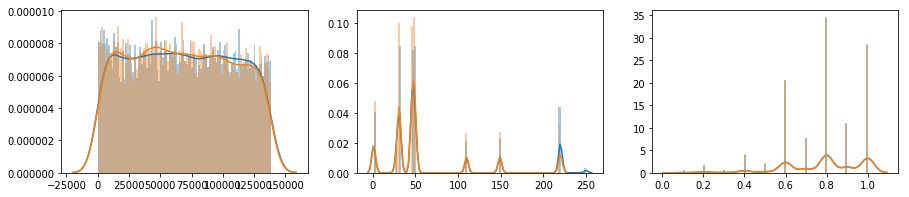

In [0]:
#Check distributions of dataset slices, if both dist are close, we can inffer the distribution between the three datasets comes from the same distribution
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
sns.distplot([sample["userId"] for sample, rating in test_ds], bins=100)
sns.distplot([sample["userId"] for sample, rating in eval_ds], bins=100)

plt.subplot(1, 3, 2)
sns.distplot([sample["movieId"] for sample, rating in test_ds], bins=100)
sns.distplot([sample["movieId"] for sample, rating in eval_ds], bins=100)

plt.subplot(1, 3, 3)
sns.distplot([rating for sample, rating in test_ds], bins=100)
sns.distplot([rating for sample, rating in eval_ds], bins=100)

plt.show()

## Matrix Factorization

Now that distributions of Datasets looks good its time for Optimize embeddings for users and movies Using classical MF technique, optimizing the dot product of two embeddings matrix.

In [0]:
#Model Definition
class MatrixFactorizer(tf.keras.Model):
  """This model will be used for optimize the embeddings, later will be discarded, just keeping the embedding layers weights"""

  def __init__(self, users, movies, emb_dim):
    super(MatrixFactorizer, self).__init__()

    self.user_emb = tf.keras.layers.Embedding(users, emb_dim)
    self.user_flat = tf.keras.layers.Flatten()

    self.movie_emb = tf.keras.layers.Embedding(movies, emb_dim)
    self.movie_flat = tf.keras.layers.Flatten()

    self.dot = tf.keras.layers.Dot(axes=1)

  def call(self, inputs):
    X_user = self.user_emb(inputs["userId"])
    X_user = self.user_flat(X_user)

    X_movie = self.movie_emb(inputs["movieId"])
    X_movie = self.movie_flat(X_movie)

    X = self.dot([X_user, X_movie])
    return X

In [0]:
#Matrix Factorizer Hyperparams
f_emb_dim = 16
f_lr = 0.0015
f_epochs = 10
f_batch_size = 40960

In [0]:
#Model instantiation
factorizer = MatrixFactorizer(n_users, n_movies, f_emb_dim)
factorizer.compile(tf.keras.optimizers.Adam(f_lr), tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
factorizer.train_on_batch(train_ds.batch(f_batch_size))
factorizer.summary()

Model: "matrix_factorizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     multiple                  2215888   
_________________________________________________________________
flatten_12 (Flatten)         multiple                  0         
_________________________________________________________________
embedding_13 (Embedding)     multiple                  427904    
_________________________________________________________________
flatten_13 (Flatten)         multiple                  0         
_________________________________________________________________
dot (Dot)                    multiple                  0         
Total params: 2,643,792
Trainable params: 2,643,792
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Model fitting
factorizer.fit(train_ds.batch(f_batch_size), epochs=f_epochs, validation_data=eval_ds)

Epoch 1/10
      1/Unknown - 1s 1s/step - loss: 0.6332 - root_mean_squared_error: 0.7958WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.250757). Check your callbacks.
488/488 [==============================] - 110s 225ms/step - loss: 0.5120 - root_mean_squared_error: 0.7156 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/10
488/488 [==============================] - 106s 218ms/step - loss: 0.1636 - root_mean_squared_error: 0.4043 - val_loss: 0.0835 - val_root_mean_squared_error: 0.2890
Epoch 3/10
488/488 [==============================] - 106s 217ms/step - loss: 0.0407 - root_mean_squared_error: 0.2018 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1913
Epoch 4/10
488/488 [==============================] - 106s 218ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1773
Epoch 5/10
488/488 [==============================] - 106s 218ms/step - loss: 0.0311 - root_m

In [0]:
#Test Performance of Factorizer
factorizer.evaluate(test_ds)

1/1 [==============================] - 0s 297ms/step - loss: 0.0282 - root_mean_squared_error: 0.1681


[0.028248749673366547, 0.16807364]

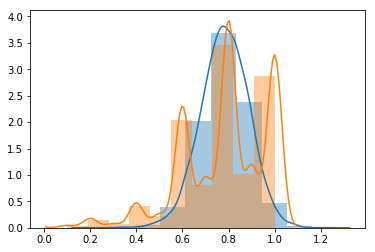

In [0]:
#Lets predict someones
pred = factorizer.predict(test_ds)
target = [target for sample, target in test_ds]

sns.distplot(pred, bins=10)
sns.distplot(target, bins=10)

In [0]:
#Above, we can see that the predictions distribution follow more or less the true distribution, but have margin for improvements
#Lets check using KLDivergence
print("KL Divergence: ", tf.keras.losses.KLDivergence()(target, pred).numpy())

KL Divergence:  0.03173639


## Matrix Factorization + Deep Feedforward Network (Neural Collaborative Filtering)

Now will use MF and MLP on a single model, also knowed as Neural Collaborative Filtering, that features a potentially complex network compared to MF, this in theory will allow us to dress the bias produced by MF model, its network is too simple for suit the problem with lower bias.

In [0]:
class DenseBlock(tf.keras.layers.Layer):
  "Dense + Dropout + BatchNorm"

  def __init__(self, units, dropout=0.1, l2=0.1):
    super(DenseBlock, self).__init__()

    self.bn = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(dropout)
    self.dense = tf.keras.layers.Dense(units, 
                                       "relu",
                                       kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                       kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):
    X = self.bn(inputs)
    X = self.drop(X)
    X = self.dense(X)
    return X

#Model Definition
class Recommender(tf.keras.Model):
  """Scores the match between an user and a movie, higher scores mean more affinity o the user for the movie"""

  def __init__(self, users, movies, emb_dim, dense_struct, dropout=0.1, l2=0.001):
    super(Recommender, self).__init__()

    self.user_emb = tf.keras.layers.Embedding(users, emb_dim)
    self.user_flat = tf.keras.layers.Flatten()
    self.user_dense = DenseBlock(emb_dim, dropout, l2)

    self.movie_emb = tf.keras.layers.Embedding(movies, emb_dim)
    self.movie_flat = tf.keras.layers.Flatten()
    self.movie_dense = DenseBlock(emb_dim, dropout, l2)

    self.concat = tf.keras.layers.Concatenate()
    
    self.dense_list = list()
    for layer in dense_struct:
      self.dense_list.append(DenseBlock(layer, dropout, l2))

    self.dense_out = tf.keras.layers.Dense(units=1, 
                                           activation="sigmoid",
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                           kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):

    X_user = self.user_emb(inputs["userId"])
    X_user = self.user_flat(X_user)
    X_user = self.user_dense(X_user)

    X_movie = self.movie_emb(inputs["movieId"])
    X_movie = self.movie_flat(X_movie)
    X_movie = self.movie_dense(X_movie)

    X = self.concat([X_user, X_movie])

    for layer in self.dense_list:
      X = layer(X)

    X = self.dense_out(X)
    return X



In [0]:
#NCF Hyperparams
r_emb_dim = 32
r_lr = 0.0005
r_epochs = 10
r_l2 = 0.0000
r_dropout = 0.0
r_batch_size = 40960
r_dense_struct = [16, 4]

In [0]:
#Model instantiation
recommender = Recommender(n_users, n_movies, r_emb_dim, r_dense_struct, r_dropout, r_l2)
recommender.compile(tf.keras.optimizers.Adam(r_lr), tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
recommender.train_on_batch(train_ds.batch(r_batch_size))
recommender.summary()

Model: "recommender_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  4431776   
_________________________________________________________________
flatten_10 (Flatten)         multiple                  0         
_________________________________________________________________
dense_block_30 (DenseBlock)  multiple                  1184      
_________________________________________________________________
embedding_11 (Embedding)     multiple                  855808    
_________________________________________________________________
flatten_11 (Flatten)         multiple                  0         
_________________________________________________________________
dense_block_31 (DenseBlock)  multiple                  1184      
_________________________________________________________________
concatenate_5 (Concatenate)  multiple                

In [0]:
#Model fit
recommender.fit(train_ds.batch(r_batch_size), epochs=r_epochs, validation_data=eval_ds)

Epoch 1/10
488/488 [==============================] - 132s 270ms/step - loss: 0.0416 - root_mean_squared_error: 0.2040 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/10
488/488 [==============================] - 129s 264ms/step - loss: 0.0321 - root_mean_squared_error: 0.1790 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2015
Epoch 3/10
488/488 [==============================] - 129s 265ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1948
Epoch 4/10
488/488 [==============================] - 129s 264ms/step - loss: 0.0294 - root_mean_squared_error: 0.1713 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1948
Epoch 5/10
488/488 [==============================] - 128s 263ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1870
Epoch 6/10
488/488 [==============================] - 132s 270ms/step - loss: 0.0284 - root_mean_squared_error: 

In [0]:
recommender.evaluate(test_ds)

1/1 [==============================] - 0s 320ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844


[0.03401268646121025, 0.18442528]

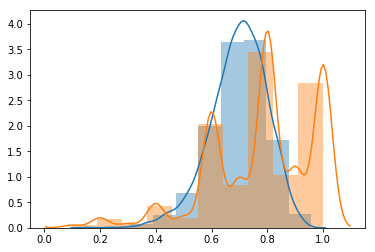

In [0]:
#Lets predict someones
pred = recommender.predict(test_ds)
target = [target for sample, target in test_ds]

sns.distplot(pred, bins=10)
sns.distplot(target, bins=10)

In [0]:
#Lets check using KLDivergence
print("KL Divergence: ", tf.keras.losses.KLDivergence()(target, pred).numpy())

KL Divergence:  0.123475365


## Conclusions

In this experiment, we cant notice improvements from adding Deep Feedforward Networks to extent the Matrix Factorization technique in serial connections. MF by itself works outstanding and with a minimal variance, while the NCF approach not only dont improve bias of the model, but adds variance. Further Experiments with other architectures with parallel connections like Neural Matrix Factorization Model (https://arxiv.org/pdf/1708.05031.pdf)